In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pymemcache.client.base import Client
import numpy
import io

# Numpy codecs

In [3]:
class NumpySerde(object):

    def serialize(key, value):
        if isinstance(value, numpy.ndarray):
            with io.BytesIO() as buffer:
                numpy.save(buffer, value)
                return buffer.getvalue(), 2
        else:
            return value, 1

    def deserialize(key, value, flags):
        if flags == 1:
            return value
        elif flags == 2:
            with io.BytesIO(value) as buffer:
                return numpy.load(buffer)
        else:
            raise RuntimeException("Unsupported serialization flags")


In [4]:
# TODO add shape, dtype
class NumpyBytesSerde(object):
    def serialize(key, value):
        if isinstance(value, numpy.ndarray):
            return value.tobytes(), 2
        else:
            return value, 1  # TODO

    def deserialize(key, value, flags):
        if flags == 1:
            return value
        elif flags == 2:
            return numpy.frombuffer(value, dtype=numpy.float32)
        else:
            raise RuntimeException("Unsupported serialization flags")


# bloscpack codec

In [5]:
import bloscpack

class NumpyBloscpackSerde(object):
    """Numpy array serializer using bloscpack"""
    BLOSC_ARGS = bloscpack.BloscArgs(cname='lz4')

    def serialize(key, value):
        if isinstance(value, numpy.ndarray):
            return bloscpack.pack_ndarray_to_bytes(value, blosc_args=NumpyBloscpackSerde.BLOSC_ARGS), 2
        else:
            return value, 1  # TODO

    def deserialize(key, value, flags):
        if flags == 1:
            return value
        elif flags == 2:
            return bloscpack.unpack_ndarray_from_bytes(value)
        else:
            raise RuntimeException("Unsupported serialization flags")

# zfp codec

In [6]:
import pyzfp

class ZFPSerde(object):
    """Numpy array serializer using zfp

    key MUST be uid_dim0,dim1,...dimN_[numpy.dtype.dtype.str]
    """
    ZFP_ARGS = {'tolerance': 0.0000001}

    def genkey(prefix, array):
        return '_'.join((prefix, ','.join(map(str, array.shape)), array.dtype.str))
        
    def serialize(key, value):
        if isinstance(value, numpy.ndarray):
            return bytes(pyzfp.compress(value, parallel=True, **ZFPSerde.ZFP_ARGS)), 2
        else:
            return value, 1  # TODO

    def deserialize(key, value, flags):
        if flags == 1:
            return value
        elif flags == 2:
            _, shape_str, dtype_str = key.rsplit('_', 2)
            shape = tuple(map(int, shape_str.split(',')))
            return pyzfp.decompress(
                value, shape, numpy.dtype(dtype_str), **ZFPSerde.ZFP_ARGS)
        else:
            raise RuntimeException("Unsupported serialization flags")


class ZFPClient(Client):
    """Thin wrapper to store shape + dtype in key"""
    def __init__(self, server):
        super().__init__(server, serde=ZFPSerde)
        self._keys = {}

    def set(self, key, value):
        if isinstance(value, numpy.ndarray):
            self._keys[key] = ZFPSerde.genkey(key, value)
            key = self._keys[key]
        return super().set(key, value)

    def get(self, key):
        return super().get(self._keys.get(key, key))


In [7]:
clientZFP = ZFPClient(('localhost', 11211))
a = numpy.linspace(0, 100, num=1000000).reshape((100, 100, 100))

%timeit clientZFP.set('data', a)
%timeit b = clientZFP.get('data')

print(numpy.linalg.norm(b-a))

ConnectionRefusedError: [Errno 111] Connection refused

# Example

In [131]:
clientLoad = Client(('localhost', 11211), serde=NumpySerde)
clientFromBuffer = Client(('localhost', 11211), serde=NumpyBytesSerde)
clientBloscPack = Client(('localhost', 11211), serde=NumpyBloscpackSerde)
clientZFP = ZFPClient(('localhost', 11211))

clients = [clientLoad, clientFromBuffer, clientBloscPack, clientZFP]

In [132]:
size = 1024
img = numpy.random.random(size*size).astype(numpy.float32).reshape(size, size)

for client in clients:
    print(client)
    %timeit client.set('img', img)
    %timeit data = client.get('img')
    #print(client, data.shape, data.dtype)
    #assert numpy.array_equal(numpy.ravel(img), numpy.ravel(data))

2.47 ms ± 46.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.13 ms ± 21.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.97 ms ± 2.32 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.11 ms ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.26 ms ± 257 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.01 ms ± 284 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.6 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
42.1 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [133]:
for client in clients:
    print(client, client.get('key6'))

<pymemcache.client.base.Client object at 0x7fd9ca02b3d0> None
<pymemcache.client.base.Client object at 0x7fd9ca02b3a0> None
<pymemcache.client.base.Client object at 0x7fd9ca02b670> None
<__main__.ZFPClient object at 0x7fd9ca02ba30> None


# Access chunks

In [8]:
template = 'data' + '[' + ','.join(['%d:%d'] * 3) + ']'

def get_data(client, s0, e0, s1, e1, s2, e2):
    key = template % (s0, e0, s1, e1, s2, e2)
    return client.get(key)

In [9]:
client = Client(('localhost', 11211), serde=NumpySerde)

slices: [ 512 , 544 ]; offset= 3


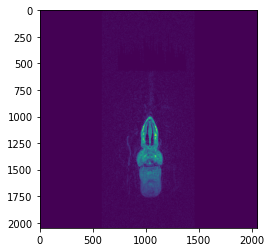

In [34]:
def get_slice_chunks(client, origin, step):
    data = numpy.zeros((step, 2048, 2048), dtype=numpy.float32)

    for row in range(0, 2048, step):
        for col in range(0, 2040, step):
            data[0:step, row:row+step, col:col+step] = get_data(client, origin, origin+step, row, row+step, col, col+step)
    return data

print('slices: [', origin, ',', origin+step, ']; offset=', offset)

slice_ = 515
step = 32

offset = slice_ % step
origin = slice_ - offset

data = get_slice_chunks(client, origin, step)

#imshow(data[offset])

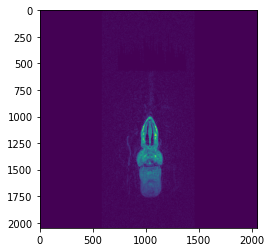

In [29]:
import h5py

with h5py.File('/users/tvincent/data/BM18/MRI3D.h5', 'r') as f:
    imshow(f['data'][515])

In [47]:
import collections.abc
import itertools
import json

import numpy
from pymemcache.client.base import Client


class NumpySerde(object):
    """pymemcache serializer/deserializer for numpy.ndarray"""

    def serialize(key, value):
        if isinstance(value, numpy.ndarray):
            with io.BytesIO() as buffer:
                numpy.save(buffer, value)
                return buffer.getvalue(), 2
        else:
            return value, 1

    def deserialize(key, value, flags):
        if flags == 1:
            return value
        elif flags == 2:
            with io.BytesIO(value) as buffer:
                return numpy.load(buffer)
        else:
            raise RuntimeException("Unsupported serialization flags")


class MemcachedArray(collections.abc.Sequence):
    """

    :param server: (host, port)
    :param str uid:
    :param kwargs: Extra arguments are passed to pymemcache Client
    """

    def __init__(self, server, uid, **kwargs):
        super().__init__()
        self.__client = Client(server, serde=NumpySerde, **kwargs)
        self.__uid = uid

        # Fetch header and set shape, dtype and chunks
        self.__get_header_info()

        self.__template = uid + '[' + ','.join(['%d:%d'] * len(self.__shape)) + ']'

    server = property(lambda self: self.__client.server)
    uid = property(lambda self: self.__uid)

    # numpy.ndarray-like
    shape = property(lambda self: self.__shape)
    ndim = property(lambda self: len(self.__shape))
    size = property(lambda self: int(numpy.prod(self.__shape)))
    dtype = property(lambda self: self.__dtype)

    # h5py.Dataset-like
    chunks = property(lambda self: self.__chunks)

    def __get_header_info(self):
        """Fetch header and set shape, dtype and chunks information"""
        header = self.__client.get(self.uid)
        if header is None:
            raise RuntimeError("Header information not available")
        header = json.loads(header)
        self.__shape = tuple(header['shape'])
        self.__dtype = numpy.dtype(header['dtype'])
        self.__chunks = tuple(header['chunks'])
        if len(self.__shape) != len(self.__chunks):
            raise RuntimeError("shape/chunks length miss-match")

    def _get(self, *indices):
        """Return chunk data from chunk indices on each dimension.
        
        :param List[int] indices: 
        """
        key = self.__template % tuple(itertools.chain.from_iterable(
            (index * size, (index + 1) * size) for index, size in zip(indices, self.chunks)))
        return self.__client.get(key)

    def _get_from_slices(self, *slices):
        key = self.__template % itertools.chain.from_iterable((s.start, s.stop) for s in slices)
        return self.__client.get(key)
        
    # Python
    def __len__(self):
        return self.shape[0]

    def __getitem__(self, key):
        # Convert key to as many indices/slices as dataset dimension
        if not isinstance(key, collections.abc.Sequence):
            key = [key]
        if len(key) < self.ndim:
            key = list(key) + [slice(None)] * (self.ndim-1)
        if len(key) > self.ndim:
            raise IndexError("too many indices for array")

        # Sanitize indices and slices:
        # Clip to shape, handle negative and out-of bound indices, slices
        # Convert to list of [start, stop[ for each dimension
        index_ranges = []
        for item, dim_size in zip(key, self.shape):
            if isinstance(item, int):
                if item < 0:
                    item = dim_size - item
                if not 0 <= item < dim_size:
                    raise IndexError("index %d is out of bounds" % item)
                index_ranges.append((item, item + 1))

            elif isinstance(item, slice):
                if item.step not in (None, 1):
                    raise NotImplementedError("Slice step is not supported")

                start, stop = item.start, item.stop
                if start is None:
                    start = 0
                if start < 0:
                    start = max(0, dim_size + start)

                if stop is None:
                    stop = dim_size
                if stop < 0:
                    stop = max(0, dim_size + stop)
                if stop > dim_size:
                    stop = dim_size

                if start >= dim_size or stop <= start:  # Empty array
                    return numpy.empty([0] * self.ndim, dtype=self.dtype)
                index_ranges.append((start, stop))

            else:
                raise IndexError("only integers and slices (`:`) are valid indices")

        # Allocate array: expect positive indices within range
        result = numpy.zeros(
            shape=[item[1] - item[0] for item in index_ranges],
            dtype=self.dtype)

        # convert to requested chunks
        chunks = [tuple(range(range_[0] // chunk_size, (range_[1] - 1) // chunk_size + 1))
                  for range_, chunk_size in zip(index_ranges, self.chunks)]
        permutation = tuple(range(1, len(chunks) + 1)) + (0,)
        all_chunk_indices = numpy.array(numpy.meshgrid(*chunks)).transpose(permutation).reshape(-1, len(chunks))

        # Get all chunks
        cache_keys = [self.__template % tuple(itertools.chain.from_iterable(
            (index * size, (index + 1) * size) for index, size in zip(indices, self.chunks)))
                      for indices in all_chunk_indices]
        data = self.__client.get_many(cache_keys)
        #    # TODO copy to result

        # slice those
        # TODO cache chunks?
        # TODO do not create dimension when it is not a slice
        return result



In [48]:
mdarray = MemcachedArray(server=('localhost', 11211), uid='data', no_delay=True)
mdarray.shape, mdarray.dtype, mdarray.chunks

((2048, 2048, 2048), dtype('float32'), (32, 32, 32))

In [49]:
%timeit mdarray[512, :, :].shape

1.33 s ± 22.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


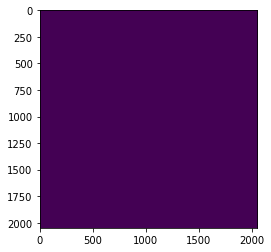

In [46]:
imshow(mdarray[512, :, :][0])

# Benchmark

Read memcached through localhost to retrieve 2048x2048 float32 of chunked data.

## chunk size (n element) -> time (sec) / time without memcached (ms)
*  5^3 -> 39s / 1000ms
* 10^3 -> 10s / 255ms
* 20^3 -> 2.8s
* 30^3 -> 1.6s
* 40^3 -> 1.25s
* 50^3 -> 1.2s  / 17ms
* 60^3 -> 1.2s
* 70^3 = 343k -> 1.3s
* 80^3 = 512k -> 1.4s  / 9ms

* 512^2 = 262k -> 27ms / 3ms
* 1024^2 = 1M -> 27ms / 3ms
* 2048^2 = 4M -> 30ms / 3ms


# Direct read through socket

In [62]:
from collections.abc import Sequence
import socket
import io
import numpy
from numpy.lib.format import read_array


class MemcachedReader:
    def __init__(self, server=('localhost', 11211)):
        self.server = server
        self.sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        #self.sock.settimeout(None)  # Connect timeout
        self.sock.connect(server)
        #self.sock.settimeout(None)  # Timeout
        #self.sock.setsockopt(socket.IPPROTO_TCP, socket.TCP_NODELAY, 1) # TCP no delay
        self._f = self.sock.makefile('rwb', newline='')

    def set(self, key, value):
        """Dummy set implementation"""
        client = Client(self.server, serde=NumpySerde)
        client.set(key, value)

    def get(self, keys):
        if isinstance(keys, (str, bytes)):
            keys = [keys]
        keys = tuple(k.encode('ascii') if isinstance(k, str) else k for k in keys)
        nresults = len(keys)
        self._f.write(b'get %s\r\n' % b' '.join(keys))
        self._f.flush()

        results = {k: None for k in keys}
        while True:
            header = self._f.readline()
            if header.startswith(b'END\r\n'):
                return results
            if header.startswith(b'ERROR'):
                raise RuntimeError()
            #assert header[-2:] == b'\r\n'
            header = header[:-2].split()
            #assert len(header) == 4
            kind, key, flags, nbytes = header
            #assert kind == b'VALUE'
            nbytes = int(nbytes)
            #array = bloscpack.unpack_ndarray_from_bytes(self._f.read(nbytes))
            results[key] = read_array(self._f)
            endline = self._f.readline()
            #assert endline == b'\r\n'
        #end = self._f.readline()
        #assert end == b'END'
        return results

    def __del__(self):
        self._f.close()
        self.sock.close()


In [63]:
reader = MemcachedReader()
reader.get(b'key6')

{b'key6': None}

# Benchmark

On localhost, with `memcached --listen=127.0.0.1 --memory-limit=65000 --max-item-size=17m`.

In [134]:
clients = {'numpy.load': Client(('localhost', 11211), serde=NumpySerde),
           'numpy.frombuffer': Client(('localhost', 11211), serde=NumpyBytesSerde),
           'socket': MemcachedReader(),
           'bloscpack+lz4': Client(('localhost', 11211), serde=NumpyBloscpackSerde),
           'zfp': ZFPClient(('localhost', 11211))}

for size in (128, 1024, 4096, 16384):
    print('* Data size:', size, 'kb')
    data = numpy.random.random(size*1024//8)  # float64
    for name, client in clients.items():
        print('-', name)
        client.set('test', data)
        %timeit client.get('test')

* Data size: 128 kb
- numpy.load
384 µs ± 3.77 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
- numpy.frombuffer
106 µs ± 1.71 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
- socket
289 µs ± 705 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
- bloscpack+lz4
364 µs ± 4.89 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
- zfp
1.23 ms ± 3.66 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
* Data size: 1024 kb
- numpy.load
924 µs ± 4.55 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
- numpy.frombuffer
535 µs ± 3.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
- socket
479 µs ± 6.07 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
- bloscpack+lz4
1.38 ms ± 55.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
- zfp
8.79 ms ± 8.11 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
* Data size: 4096 kb
- numpy.load
3.12 ms ± 23.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
- nump